In [13]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit #, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
#from qiskit.extensions import XGate
#from ibm_washington_config import coupling_map, basis_gates
#from ionq_config import coupling_map, basis_gates

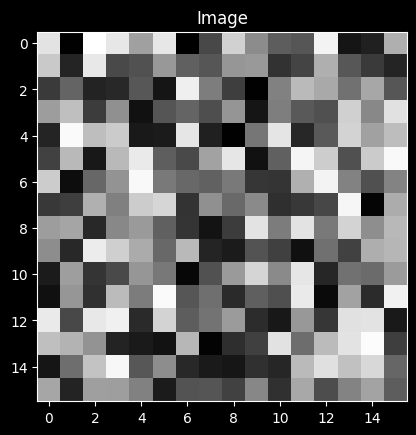

In [14]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

sort pixels

In [15]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [16]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

In [17]:
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_image = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.id(color)
qc_image.id(coordinate)
qc_image.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=color[0])
        else:
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=coordinate[0])
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
                
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 35  | 4 | 412| 199|
| 4  | 943  | 6 | 5513| 1855|
| 8  | 16063  | 8 | 97739| 31999|
| 16  | 260863  | 10 | | 521215|
| 32  | 4189183  | 12|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

In [18]:
mpl_circuit = qc_image.draw(output='mpl')
mpl_circuit

ValueError: Image size of 2328x289913 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2328.53x289913 with 1 Axes>

Error in callback <function _draw_all_if_interactive at 0x10ca19bc0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2328x289913 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2328x289913 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2328.53x289913 with 1 Axes>

In [19]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 4351, # of qubits is 10


In [20]:
from qiskit import transpile
from qiskit_aer import AerSimulator

# Create the AerSimulator backend
aer_sim = AerSimulator()

# Transpile the quantum circuit for the simulator
t_qc_image = transpile(qc_image, aer_sim)

# Run the simulation with the specified number of shots
job_oqim = aer_sim.run(t_qc_image, shots=100000)

# Get the result of the simulation
result_oqim = job_oqim.result()

# Retrieve the measurement counts
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((key[0], amount))
                coord_list.append((key[1], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

the meauserd colors are 
 [225   0 256 226 157 228   0  70 207 134  91  78 236  19  40 179 201  34
 235  73  80 146  93  87 150 156  49  65 167  77  55  35  58 100  33  42
  92  14 233 123  56   0 123 183 162 113 159  83 156 188  61 149  21  87
  98  76 152  14 122  91  78 210 135 224  34 244 198 196  23  24 226  31
   0 123 224  42  90 210 159 185  61 179  21 184 236  98  65 163 230  16
 106 239 205  79 205 247 199   8  98 150 244 125  95  93 118  52  52 171
 256 126  79 129  53  59 170 127 210 214  48 138 109 134  44  58  71 244
   0 167 159 165  38 131 157  97  49  19  58 226 124 217 121 211 138 186
 143  37 237 214 171 110 178  35  27  88  64  16 110  62 176 176  28 153
  56  76 148 115   0  76 146 216 140 229  38 114 103 158  19 146  45 186
 124 247  83 116  38  84  79 231  11 163  42 236 235  68 229 238  48 211
  96 110 151  51  18 146  54 222 233  24 202 179 149  36  16  18 184   0
  47  67 219 107 181 228 243  70  26 114 188 247  88 135  43  26  14  46
  32 180 225 189 214 101 

As we can see above, probabilistic amplitude <ins>coordinate</ins> encoding fails

In [21]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

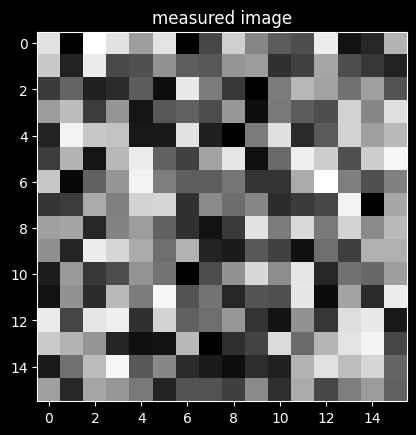

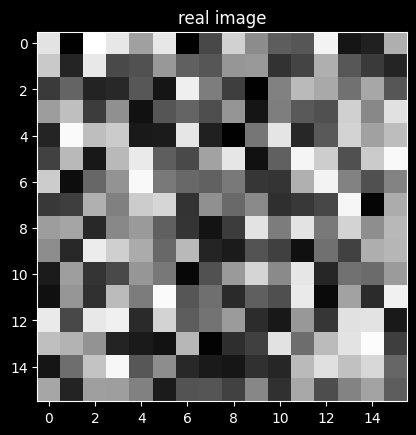

In [22]:
plot_to_compare(output_im, image)